In [1]:
import numpy as np
import pandas as pd
import re,string,unicodedata
import os

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

In [2]:
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


In [3]:

true = pd.read_csv("true.csv")
fake = pd.read_csv("fake.csv")
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [4]:
true['category']=1
fake['category']=0

In [5]:
concat_df = pd.concat([true,fake])
concat_df.sample(10)

,title,text,subject,date,category
7850,"Trump assails House speaker Ryan, McCain as 'd...",WASHINGTON (Reuters) - Republican presidential...,politicsNews,"October 11, 2016",1
2287,"After sanctions, Tillerson may find Russia tal...",WASHINGTON (Reuters) - U.S. Secretary of State...,politicsNews,"August 5, 2017",1
12016,"YES, Obama CAN Appoint A Supreme Court Justice...",The President who has thumbed his nose at our ...,politics,"Jan 2, 2017",0
7991,Fox Airs Footage Of Riots While Covering Pres...,"In a despicable bit of biased news coverage, F...",News,"February 19, 2016",0
16002,FARMER FINED A WHOPPING $2.8 MILLION Asks Pres...,A California farmer fined $2.8 million for plo...,Government News,"Jul 29, 2017",0
17458,U.S.-backed SDF to let Syrian Islamic State fi...,"AIN ISSA, Syria/BEIRUT (Reuters) - Syrian Isla...",worldnews,"October 14, 2017",1
7289,"WATCH: Trump Supporter Drops Bombshell, Accus...",A conservative columnist and Trump supporter d...,News,"March 25, 2016",0
18163,SKETCHY FIRM BEHIND SALACIOUS ALLEGATIONS Agai...,Remember Fusion GPS (please see our previous r...,left-news,"Aug 11, 2017",0
12740,JUDGE JEANINE PIRRO Rips Into The Lying Media ...,,politics,"Oct 14, 2016",0
19410,OHIO ELECTOR TORCHES Anti-Trump Letters He Rec...,pic.twitter.com/KMnLrwB6t1 Richard K. Jones (...,left-news,"Dec 21, 2016",0


In [31]:
print(true['title'].iloc[0],true['text'].iloc[0],sep='\n')

As U.S. budget fight looms, Republicans flip their fiscal script
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [6]:
concat_df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [7]:
concat_df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [8]:
concat_df.duplicated().sum()

209

In [9]:
concat_df.drop_duplicates(inplace=True)
concat_df.shape

(44689, 5)

In [10]:
concat_df['text'] = concat_df['title'] + " " + concat_df['text']

In [11]:
del concat_df['title']
del concat_df['subject']
del concat_df['date']

In [12]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
# Final function to clean the text
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text
#Apply function on review column
concat_df['text']=concat_df['text'].apply(lambda x: clean_text(x))

/N/u/avmett/BigRed200/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  


In [14]:
concat_df.head(10)

,text,category
0,us budget fight looms republicans flip fiscal ...,1
1,us military accept transgender recruits monday...,1
2,senior us republican senator let mr mueller jo...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge much more am...,1
5,white house congress prepare talks spending im...,1
6,trump says russia probe fair timeline unclear ...,1
7,factbox trump twitter dec 29 approval rating a...,1
8,trump twitter dec 28 global warming following ...,1
9,alabama official certify senatorelect jones to...,1


In [15]:
concat_df['text'] = concat_df['text'].apply(lambda x: word_tokenize(str(x)))
concat_df.head(10)

,text,category
0,"[us, budget, fight, looms, republicans, flip, ...",1
1,"[us, military, accept, transgender, recruits, ...",1
2,"[senior, us, republican, senator, let, mr, mue...",1
3,"[fbi, russia, probe, helped, australian, diplo...",1
4,"[trump, wants, postal, service, charge, much, ...",1
5,"[white, house, congress, prepare, talks, spend...",1
6,"[trump, says, russia, probe, fair, timeline, u...",1
7,"[factbox, trump, twitter, dec, 29, approval, r...",1
8,"[trump, twitter, dec, 28, global, warming, fol...",1
9,"[alabama, official, certify, senatorelect, jon...",1


In [16]:
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
concat_df['text'] = concat_df['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(token) for token in x]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /N/u/avmett/BigRed200/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
concat_df.head(10)

,text,category
0,u budget fight loom republican flip fiscal scr...,1
1,u military accept transgender recruit monday p...,1
2,senior u republican senator let mr mueller job...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much more ama...,1
5,white house congress prepare talk spending imm...,1
6,trump say russia probe fair timeline unclear n...,1
7,factbox trump twitter dec 29 approval rating a...,1
8,trump twitter dec 28 global warming following ...,1
9,alabama official certify senatorelect jones to...,1


In [18]:
X = concat_df.text
y = concat_df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7,stratify=y, random_state=19)

# Create the TF-IDF object
tfidf=TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features=9000)

# Transform the train dataset
tfidf_train=tfidf.fit_transform(X_train)
X_train_arr = tfidf_train.toarray()
# Transform the test dataset
tfidf_test=tfidf.transform(X_test)
X_test_arr = tfidf_test.toarray()
print('TF-IDF Train:',tfidf_train.shape)
print('TF-IDF Test:',tfidf_test.shape)

TF-IDF Train: (31282, 9000)
TF-IDF Test: (13407, 9000)


In [19]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
selector = SelectKBest(score_func=f_classif,k=50)
x_train = selector.fit_transform(X_train_arr,y_train)
x_test = selector.fit_transform(X_test_arr,y_test)

In [20]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.ensemble import VotingClassifier
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(x_train, y_train)
VotingClassifiers.score(x_train,y_train),VotingClassifiers.score(x_test,y_test)

(0.9691835560386165, 0.9453270679495785)

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      7044
           1       0.90      0.99      0.95      6363

    accuracy                           0.95     13407
   macro avg       0.95      0.95      0.95     13407
weighted avg       0.95      0.95      0.95     13407



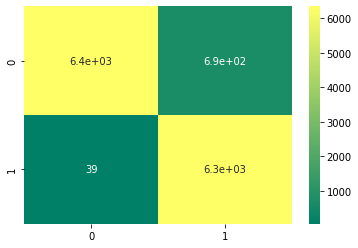

In [21]:
y_act=y_test
y_pred=VotingClassifiers.predict(x_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4],'criterion':['entropy'],
                                                      'max_depth':range(1,5),'min_samples_split':range(2,6)},random_state=12)
classifiers.fit(x_train, y_train)
print('Training score:',classifiers.score(x_train, y_train))
print('Testing score:',classifiers.score(x_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.9878844063678793
Testing score: 0.6561497725068994
RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=4,
                       n_estimators=4)


              precision    recall  f1-score   support

           0       0.61      0.97      0.75      7044
           1       0.91      0.31      0.46      6363

    accuracy                           0.66     13407
   macro avg       0.76      0.64      0.60     13407
weighted avg       0.75      0.66      0.61     13407



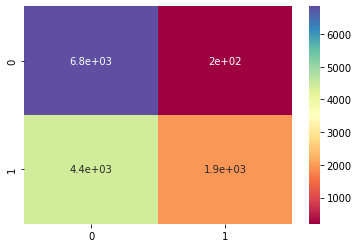

In [23]:
#confusion matrix and classification report
y_act=y_test
y_pred=classifiers.predict(x_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral')
print(classification_report(y_act,y_pred))

In [24]:
from xgboost import XGBClassifier
model = XGBClassifier( eval_metric='map',max_depth=200,n_estimators=70,learning_rate=1.99)
model.fit(x_train,y_train)
print('Training score:',model.score(x_train,y_train))
print('Testing score:',model.score(x_test,y_test))

/N/u/avmett/BigRed200/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training score: 1.0
Testing score: 0.5933467591556649


              precision    recall  f1-score   support

           0       0.56      0.98      0.72      7044
           1       0.90      0.16      0.27      6363

    accuracy                           0.59     13407
   macro avg       0.73      0.57      0.50     13407
weighted avg       0.72      0.59      0.51     13407



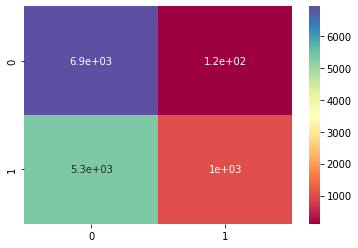

In [25]:
#confusion matrix and classification report
y_act = y_test
y_pred = model.predict(x_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral')
print(classification_report(y_act,y_pred))

In [26]:
from sklearn.ensemble import AdaBoostClassifier
RandomForest = RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=4,
                        n_estimators=8)
AddaBoosts = AdaBoostClassifier(base_estimator =RandomForest,n_estimators=70,learning_rate=2.38,random_state=1)
AddaBoosts.fit(x_train,y_train)
print('Training score:',AddaBoosts.score(x_train,y_train))
print('Testing score:',AddaBoosts.score(x_test,y_test))

Training score: 1.0
Testing score: 0.6591332885805923


              precision    recall  f1-score   support

           0       0.61      0.98      0.75      7044
           1       0.93      0.30      0.46      6363

    accuracy                           0.66     13407
   macro avg       0.77      0.64      0.61     13407
weighted avg       0.76      0.66      0.61     13407



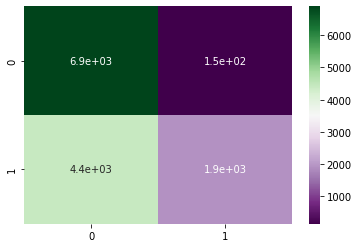

In [27]:
y_act = y_test
y_pred = AddaBoosts.predict(x_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PRGn')
print(classification_report(y_act,y_pred))

In [28]:
from sklearn.neighbors import KNeighborsClassifier
model = RandomizedSearchCV(KNeighborsClassifier(),{'n_neighbors':[10],'metric':['manhattan','minkowski','cosine','tanimoto'],
                                                   'p':[1,2]},random_state=8,n_jobs=-1)
model.fit(x_train, y_train)
print('Training score:',model.score(x_train, y_train))
print('Testing score:',model.score(x_test,y_test))
print(model.best_estimator_)

/N/u/avmett/BigRed200/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/N/u/avmett/BigRed200/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.97074993 0.97074993 0.97074993 0.95355152 0.94197895 0.94197895
        nan        nan]
  category=UserWarning


Training score: 0.9754491400805575
Testing score: 0.7643768180801074
KNeighborsClassifier(metric='manhattan', n_neighbors=10, p=1)


              precision    recall  f1-score   support

           0       0.70      0.98      0.81      7044
           1       0.96      0.52      0.68      6363

    accuracy                           0.76     13407
   macro avg       0.83      0.75      0.75     13407
weighted avg       0.82      0.76      0.75     13407



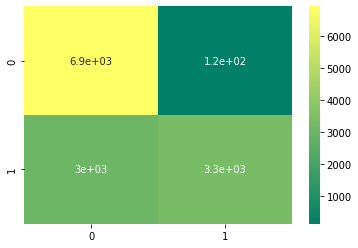

In [29]:
y_act = y_test
y_pred = model.predict(x_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [51]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
# Final function to clean the text
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

def pre_process(title,body):
    text = title+" "+body
    
    text = clean_text(text)
    tokens = word_tokenize(text)
    lemmas = " ".join([lemmatizer.lemmatize(token) for token in tokens])
#     print(lemmas)
    tfidf_vector = tfidf.transform([lemmas])
    X = tfidf_vector.toarray()
    red_x = selector.transform(X)
    return red_x
    

In [52]:
x=pre_process("As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid.")

In [43]:
import pickle
with open("ensemble_nb.pkl",'wb') as f:
    pickle.dump(VotingClassifiers,f)
with open("tfidf_fnd.pkl",'wb') as f:
    pickle.dump(tfidf,f)
with open("KBestSelector.pkl",'wb') as f:
    pickle.dump(selector,f)

In [49]:
x

In [54]:
VotingClassifiers.predict_proba(x)

array([[0.07985332, 0.92014668]])